In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler #ADASYN, SMOTE
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from math import sqrt
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:

pd.options.display.max_rows = 20
pd.options.display.max_columns = 50

In [3]:
#read in the data
data = pd.read_feather(r'/media/kchen/2TB/kchen_backup/ssi/data/procol_train.feather')
y = data['ssi']
X = data.drop(['SUPINFEC','WNDINFD','ORGSPCSSI','ssi'], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)

test = pd.read_feather(r'/media/kchen/2TB/kchen_backup/ssi/data/procol_test.feather')
y_test = test['ssi']
X_test = test.drop(['SUPINFEC','WNDINFD','ORGSPCSSI','ssi'], axis=1)

In [4]:
data.shape

(223902, 71)

In [5]:
y_train.value_counts(normalize=True)

0    0.89286
1    0.10714
Name: ssi, dtype: float64

In [6]:
#input shape is shape of training data
input_shape = [X_train.shape[1]]

In [7]:
#define the model and train, using hyperparameters from randomsearch
model4 = tf.keras.models.Sequential()
model4.add(tf.keras.layers.Flatten(input_shape=input_shape))
model4.add(tf.keras.layers.BatchNormalization())
for _ in range(1):
    model4.add(tf.keras.layers.Dense(500))
    model4.add(tf.keras.layers.BatchNormalization())
    model4.add(tf.keras.layers.Dropout(0.8))
    model4.add(tf.keras.layers.Activation("relu"))
model4.add(tf.keras.layers.Dense(1, activation="sigmoid"))

opt = tf.keras.optimizers.Adam(learning_rate=3e-3)

metrics = [tf.keras.metrics.Recall(name='Sensitivity'), tf.keras.metrics.TrueNegatives(name='tn'), tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.AUC(name='prc', curve='PR')]

model4.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=metrics,)

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=25,
    min_delta=1e-8,
    restore_best_weights=True,)

history = model4.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=500,
    callbacks=[early_stopping],)

Instructions for updating:
Colocations handled automatically by placer.
Train on 179121 samples, validate on 44781 samples


2022-01-13 13:17:12.079060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-13 13:17:12.087780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-13 13:17:12.088315: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-13 13:17:12.089332: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/500
172544/179121 [===========================>..] - ETA: 0s - loss: 0.3183 - Sensitivity: 0.2152 - tn: 152592.0000 - auc: 0.6757 - prc: 0.3701

/home/kchen/.local/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


179121/179121 [==============================] - 2s 11us/sample - loss: 0.3169 - Sensitivity: 0.2150 - tn: 158483.0000 - auc: 0.6767 - prc: 0.3709 - val_loss: 0.2813 - val_Sensitivity: 0.2029 - val_tn: 39966.0000 - val_auc: 0.7334 - val_prc: 0.4192
Epoch 2/500
179121/179121 [==============================] - 1s 7us/sample - loss: 0.2834 - Sensitivity: 0.2133 - tn: 159904.0000 - auc: 0.7106 - prc: 0.4069 - val_loss: 0.2758 - val_Sensitivity: 0.2037 - val_tn: 39966.0000 - val_auc: 0.7401 - val_prc: 0.4251
Epoch 3/500
179121/179121 [==============================] - 1s 8us/sample - loss: 0.2803 - Sensitivity: 0.2133 - tn: 159908.0000 - auc: 0.7192 - prc: 0.4170 - val_loss: 0.2761 - val_Sensitivity: 0.2037 - val_tn: 39966.0000 - val_auc: 0.7433 - val_prc: 0.4276
Epoch 4/500
179121/179121 [==============================] - 2s 8us/sample - loss: 0.2779 - Sensitivity: 0.2133 - tn: 159921.0000 - auc: 0.7246 - prc: 0.4216 - val_loss: 0.2745 - val_Sensitivity: 0.2037 - val_tn: 39966.0000 - val_a

In [8]:
#get predictions
ann_preds = model4.predict(X_test)
%store ann_preds_ssi

/home/kchen/.local/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
UsageError: Unknown variable 'ann_preds_ssi'


In [9]:
#get tpr and fpr for roc curve
ann_fpr_ssi, ann_tpr_ssi, _ = roc_curve(y_test, ann_preds)
%store ann_fpr_ssi
%store ann_tpr_ssi


Stored 'ann_fpr_ssi' (ndarray)
Stored 'ann_tpr_ssi' (ndarray)


In [10]:
#calculate 95% confidence interval for auroc
def roc_auc_ci(y_true, y_score, positive=1):
    AUC = roc_auc_score(y_true, y_score)
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, AUC, upper)
roc_auc_ci(y_test, ann_preds)

(0.7576182098662867, 0.7652692564307881, 0.7729203029952896)

In [11]:
#get precision and recall for pr curve
ann_prec_ssi, ann_rec_ssi, _ = precision_recall_curve(y_test, ann_preds)
%store ann_prec_ssi
%store ann_rec_ssi

Stored 'ann_prec_ssi' (ndarray)
Stored 'ann_rec_ssi' (ndarray)


In [12]:
#get 95% confidence interval for pr curve
def roc_prc_ci(y_true, y_score, positive=1):
    AUC = average_precision_score(y_true, y_score)
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, AUC, upper)
roc_prc_ci(y_test, ann_preds)

(0.47315313187669433, 0.4812235246362579, 0.48929391739582145)

In [13]:
#get p-value for ann vs lr using Delong method from https://biasedml.com/roc-comparison/
%store -r ann_preds
%store -r lr_preds
from matplotlib import pyplot as plt
import scipy.stats as st
from sklearn import metrics

def auc(X, Y):
    return 1/(len(X)*len(Y)) * sum([kernel(x, y) for x in X for y in Y])
def kernel(X, Y):
    return .5 if Y==X else int(Y < X)
def structural_components(X, Y):
    V10 = [1/len(Y) * sum([kernel(x, y) for y in Y]) for x in X]
    V01 = [1/len(X) * sum([kernel(x, y) for x in X]) for y in Y]
    return V10, V01
    

def get_S_entry(V_A, V_B, auc_A, auc_B):
    return 1/(len(V_A)-1) * sum([(a-auc_A)*(b-auc_B) for a,b in zip(V_A, V_B)])
def z_score(var_A, var_B, covar_AB, auc_A, auc_B):
    return (auc_A - auc_B)/((var_A + var_B - 2*covar_AB)**(.5))


preds_A = ann_preds
preds_B = lr_preds
actual = y_test

actual = actual.array

def group_preds_by_label(preds, actual):
    X = [p for (p, a) in zip(preds, actual) if a]
    Y = [p for (p, a) in zip(preds, actual) if not a]
    return X, Y


X_A, Y_A = group_preds_by_label(preds_A, actual)
X_B, Y_B = group_preds_by_label(preds_B, actual)
V_A10, V_A01 = structural_components(X_A, Y_A)
V_B10, V_B01 = structural_components(X_B, Y_B)
auc_A = auc(X_A, Y_A)
auc_B = auc(X_B, Y_B)


# Compute entries of covariance matrix S (covar_AB = covar_BA)
var_A = (get_S_entry(V_A10, V_A10, auc_A, auc_A) * 1/len(V_A10)
        + get_S_entry(V_A01, V_A01, auc_A, auc_A) * 1/len(V_A01))
var_B = (get_S_entry(V_B10, V_B10, auc_B, auc_B) * 1/len(V_B10)
        + get_S_entry(V_B01, V_B01, auc_B, auc_B) * 1/len(V_B01))
covar_AB = (get_S_entry(V_A10, V_B10, auc_A, auc_B) * 1/len(V_A10)
            + get_S_entry(V_A01, V_B01, auc_A, auc_B) * 1/len(V_A01))

# Two tailed test
z = z_score(var_A, var_B, covar_AB, auc_A, auc_B)

p = st.norm.sf(abs(z[x-1]))*2
p

no stored variable or alias lr_preds


NameError: name 'lr_preds' is not defined

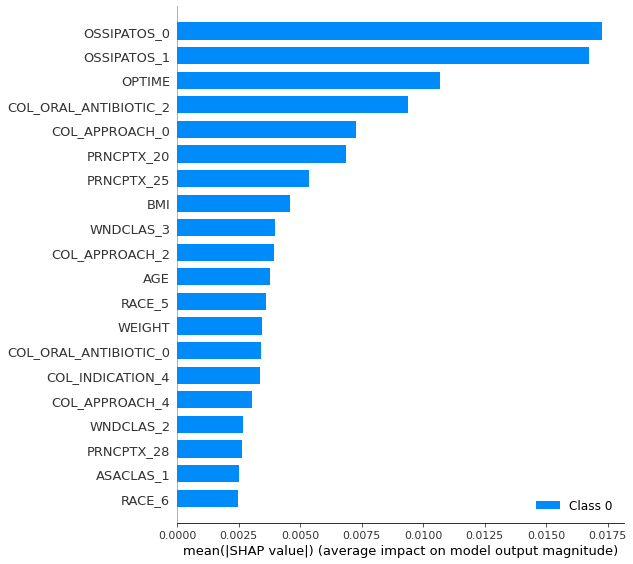

In [ ]:
import shap
explainer = shap.DeepExplainer(model4, X_train.sample(n=4000))
shap_values = explainer.shap_values(X_valid.sample(n=4000).values)
shap.summary_plot(shap_values, X_valid.sample(n=4000))

In [ ]:
#create a dataframe of the shap values sorted from highest to lowest
shap_values[0].shape
vals = np.abs(shap_values[0]).mean(0)
feature_names = X_train.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
feature_importance.head(10)

,col_name,feature_importance_vals
25,OSSIPATOS_0,0.017287
26,OSSIPATOS_1,0.016736
15,OPTIME,0.010695
157,COL_ORAL_ANTIBIOTIC_2,0.009399
120,COL_APPROACH_0,0.007284
64,PRNCPTX_20,0.006860
69,PRNCPTX_25,0.005341
21,BMI,0.004568
220,WNDCLAS_3,0.003986
122,COL_APPROACH_2,0.003938


In [ ]:
#export the dataframe to excel (easier to change the column names)
feature_importance.to_excel('shap.xlsx')

In [ ]:
#read the excel file back in after the column names have been changed
fi = pd.read_excel('shap.xlsx')

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
#makes the darkest blue at the top and lightest blue at the bottom
palette = sns.color_palette("Blues_d", n_colors=10)
palette.reverse()

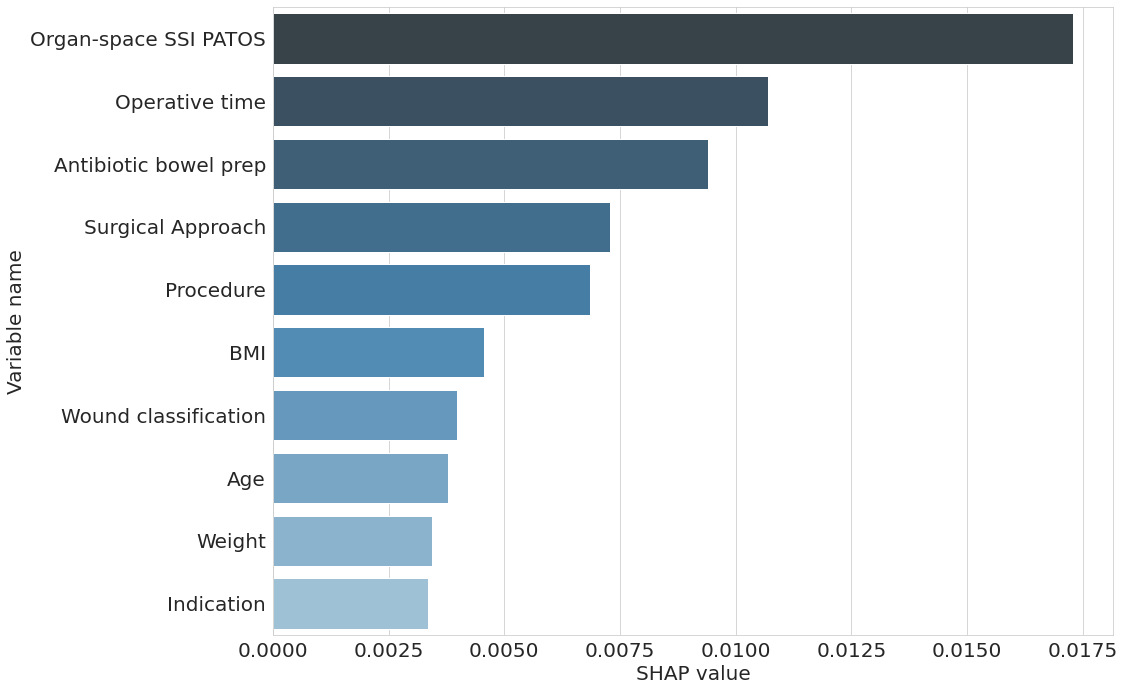

In [ ]:
#create a horizontal bar plot of the top 10 features
plt.figure(figsize=(16,10))
sns.barplot(x='SHAP value', y='Variable name', data=fi.head(10), palette=palette)
#increase font size
plt.tight_layout()
plt.rcParams["font.size"] = 20
plt.savefig('shap_top10.png')